# DATA 620 - Assignment 3

by: Jeremy OBrien and Mael Illien

Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)), please feel free at this point to load just a small subset of the nodes and edges.

Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.

Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information. Please record a short video (~ 5 minutes), and submit a link to the video in advance of our meet-up.

Our plan for Assignment 3 is as follows:
1. Load a publicly available, open-source graph dataset
2. Downsample the graph for ease of visualization
3. Visualize the graph using Neo4j
4. Retrieve data from Neo4j using a Python connector
5. Calculate diagnostics using NetworkX

In [1]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from neo4jconfig import neo4j_auth
%matplotlib inline

For Assignment 3 we sourced a Bitcoin OTC trusted weighted signed network dataset from the [Stanford Network Analysis Project](https://snap.stanford.edu/data/soc-sign-bitcoin-otc.html).

[Bitcoin OTC](https://www.bitcoin-otc.com/) is an over-the-counter marketplace for trading bitcoin which also offers a web-of-trust service.  The dataset captures a who-trusts-whom network of anonymous individuals using the Bitcoing OTC platform.  From the perspective of network topology, individuals comprise nodes, relationships are directed edges, and edge weights are trust ratings provided by one user (source node) of another user (target node) on a scale of -10 (total distrust) through 0 (neutral) to +10 (total trust).

This dataset is credited to:
- S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. [Edge Weight Prediction in Weighted Signed Networks](https://cs.stanford.edu/~srijan/pubs/wsn-icdm16.pdf). IEEE International Conference on Data Mining (ICDM), 2016.
- S. Kumar, B. Hooi, D. Makhija, M. Kumar, V.S. Subrahmanian, C. Faloutsos. [REV2: Fraudulent User Prediction in Rating Platforms](https://cs.stanford.edu/~srijan/pubs/rev2-wsdm18.pdf). 11th ACM International Conference on Web Searchand Data Mining (WSDM), 2018.

In [2]:
# Import data using pandas
url = 'https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/soc-sign-bitcoinotc.csv'
ratings = pd.read_csv(url, names=['SOURCE','TARGET','RATING','TIMESTAMP'] )
ratings

,SOURCE,TARGET,RATING,TIMESTAMP
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
...,...,...,...,...
35587,4499,1810,1,1.453612e+09
35588,2731,3901,5,1.453679e+09
35589,2731,4897,5,1.453679e+09
35590,13,1128,1,1.453680e+09


#### Load data into a graph using NetworkX

In [3]:
# Compose a directed graph of Bitcoin OTC users
data = open('soc-sign-bitcoinotc.csv', 'r')
graphtype = nx.DiGraph()
graph = nx.parse_edgelist(data, 
                      delimiter=',', 
                      create_using=graphtype,
                      nodetype=int, 
                      data=(('weight', float),('time', float)))

In [4]:
# Calculate number of users
len(graph.nodes)

5881

In [5]:
# Calculate number of ratings
len(graph.edges)

35592

#### Downsample the full graph

Given the large size of the Bitcoin OTC network, we'll downsample the number of nodes to reduce the computational resources needed for this Assignment 3.  We use the following procedure:
1. Randomly sample 50 users from the full network, which will serve as source nodes
2. Map other users rated by this random user sample, tracing the outbound directed edges from these source nodes (target nodes)

In [6]:
# Randomly sample 50 users
unique_users = set(ratings['SOURCE']) # Identify unique users
downsample_n = 50 # Set source node sample 
random.seed(620)
ratings_subset = ratings[ratings['SOURCE'].isin(random.sample(unique_users, downsample_n))]

# Create a list of unique nodes to create
source_nodes = list(set(ratings_subset['SOURCE']))
target_nodes = list(set(ratings_subset['TARGET']))
all_nodes = source_nodes + target_nodes

# Calculate total nodes in random sample
print(len(source_nodes),len(target_nodes),len(all_nodes))

50 475 525


The downsampling procedure yields a smaller, shallower directed graph of 525 total nodes.  This graph will be more amenable to easy visualization than the full graph.

In [7]:
ratings_subset.head()

,SOURCE,TARGET,RATING,TIMESTAMP
90,41,36,2,1.292206e+09
127,41,75,1,1.293584e+09
139,41,60,1,1.293820e+09
148,41,4,1,1.294081e+09
159,41,83,1,1.294263e+09


In [8]:
# Reset the index of sample graph
ratings_subset = ratings_subset.reset_index()

### Load sample graph into Neo4j

In order to visualize the sample graph, we first load the data into Neo4j using Pandas to output separate nodes and edges CSV files.

In [9]:
# Output nodes from sample graph to CSV
df = pd.DataFrame(all_nodes)
df.columns = ['usr_id']
#df
df.to_csv('nodes.csv')

In [10]:
# Output directed edges and weights (ratings) from sample graph to CSV
df = ratings[ratings['SOURCE'].isin(list(source_nodes))]
df = df[['SOURCE','TARGET','RATING']]
df.columns = ['SOURCE','TARGET','RATING']
#df
df.to_csv('edges.csv')

In [11]:
# Create nodes in Neo4j
"""LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/nodes.csv" AS csvLine
CREATE (u:User {usr_id: (csvLine.usr_id)})"""

'LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/nodes.csv" AS csvLine\nCREATE (u:User {usr_id: (csvLine.usr_id)})'

In [12]:
# Create edges in Neo4j
"""LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/edges.csv" AS csvLine
MATCH (u1:User {usr_id: csvLine.SOURCE})
MATCH (u2:User {usr_id: csvLine.TARGET})
CREATE (u1)-[:TRUSTS {rating: csvLine.RATING}]->(u2)"""

'LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/edges.csv" AS csvLine\nMATCH (u1:User {usr_id: csvLine.SOURCE})\nMATCH (u2:User {usr_id: csvLine.TARGET})\nCREATE (u1)-[:TRUSTS {rating: csvLine.RATING}]->(u2)'

### Visualize sample graph using Neo4j

Neo4j visualizations of the sampled graph and central subgraph are shown below.  It's not possible to say if network characteristics are shared by the full graph or purely a result of our sampling procedure.  From a visual analysis, we do note the following:
- Three relatively dense neighborhoods concentrated near the center, with centroids (2279,2304 and 2260) mostly connected to end nodes but also to other parts of the network, thereby spanning the connection.
- A few isolated small networks on the periphery which are the result of sampling source users.

![Neo4j Graph](https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/graph.png)

From the graph above, we can pick out the central network in the center to investigate further. Here is the resulting subgraph for the network:

![Neo4j Graph](https://raw.githubusercontent.com/JeremyOBrien16/CUNY_DATA_620/master/Assignment03/subgraph.png)

### Export graph from Neo4j into NetworkX

In [13]:
# Connect to a Neo4j database using the neo4j python connector
gdb = GraphDatabase.driver(uri=neo4j_auth['uri'],auth=(neo4j_auth['user'],neo4j_auth['password']), encrypted=False)
session = gdb.session()

In [14]:
# Return all nodes
node_ids = []
with gdb.session() as session:
    result = session.run("MATCH (u:User) RETURN u.usr_id AS id")
    
node_ids = [record["id"] for record in result]
print(len(node_ids))

525


In [15]:
# Return all links
links = []
with gdb.session() as session:
    query = "MATCH (u1:User)-[r:TRUSTS]->(u2:User) RETURN u1.usr_id AS id1, u2.usr_id AS id2, r.rating as rating"
    result = session.run(query)
    
links = [(record["id1"],record["id2"],record["rating"]) for record in result]
print(len(links))

594


In [16]:
# Construct the graph using the edges
def create_graph():
    graph = nx.Graph()
    
    for link in links:
        graph.add_edge(link[0], link[1], weight=link[2])
            
    return graph

In [17]:
g = create_graph()
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 523
Number of edges: 586
Average degree:   2.2409


### Visualize graph in Networkx

The Networkx visualization differs in appearance due to the overlap of concentrated of nodes. However, we notice the same 3-4 centroids in the network that were identified in Neo4j

In [18]:
# Make figures bigger
plt.rcParams['figure.figsize'] = [20, 10]

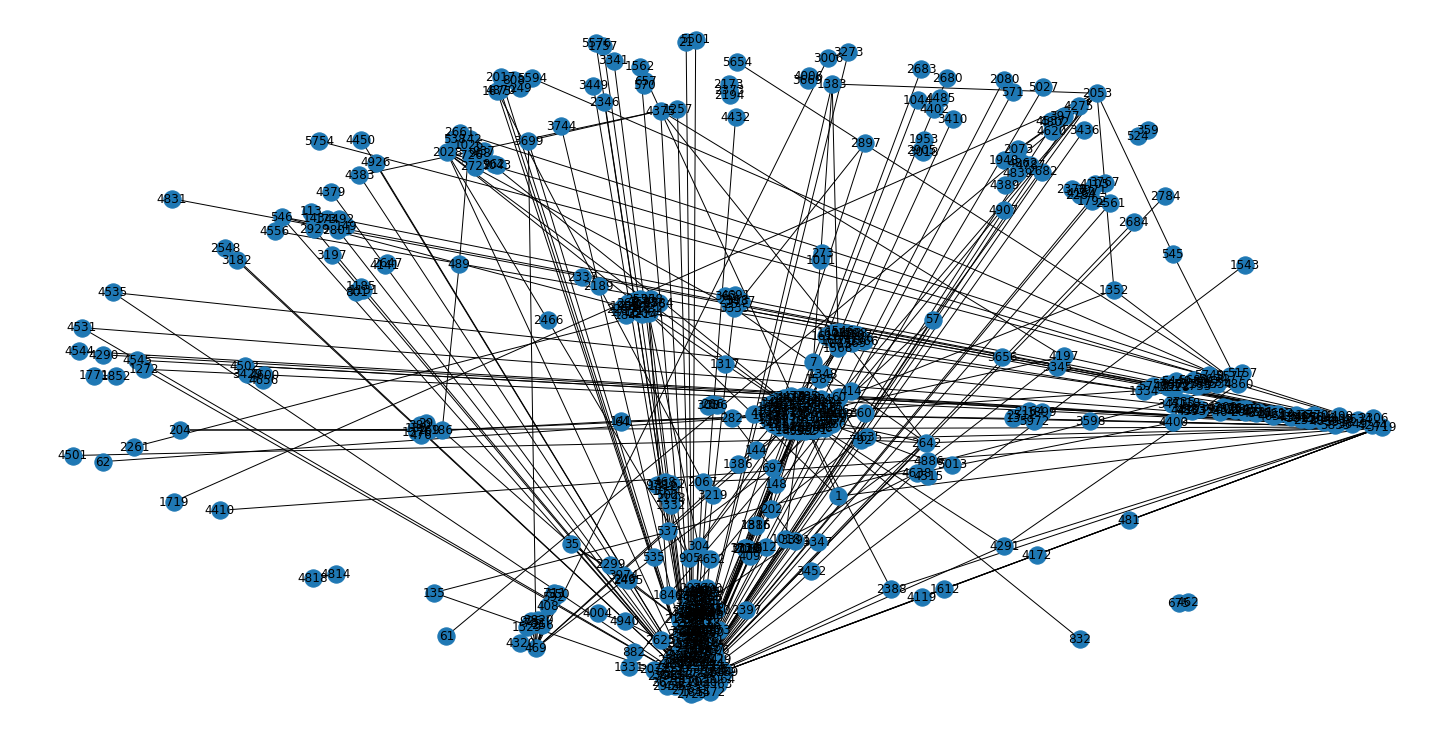

In [19]:
nx.draw(g, with_labels=True)

To aid with visualization, we trim down the graph by iteratively eliminating nodes with degree less than 1. This ensures that the resulting graph will be finite, which will allows us to compute some diagnostics.

In [20]:
import copy
trim = copy.copy(g)

small = [n for n in g.nodes if g.degree[n] <= 1]
while small != []:
    small = [n for n in trim.nodes if trim.degree[n] <= 1]
    trim.remove_nodes_from(small)

print(nx.info(trim))


Name: 
Type: Graph
Number of nodes: 90
Number of edges: 170
Average degree:   3.7778


The trimmed graph is easier to work with and the shell representation below clearly shows nodes with many branches spanning out of them.

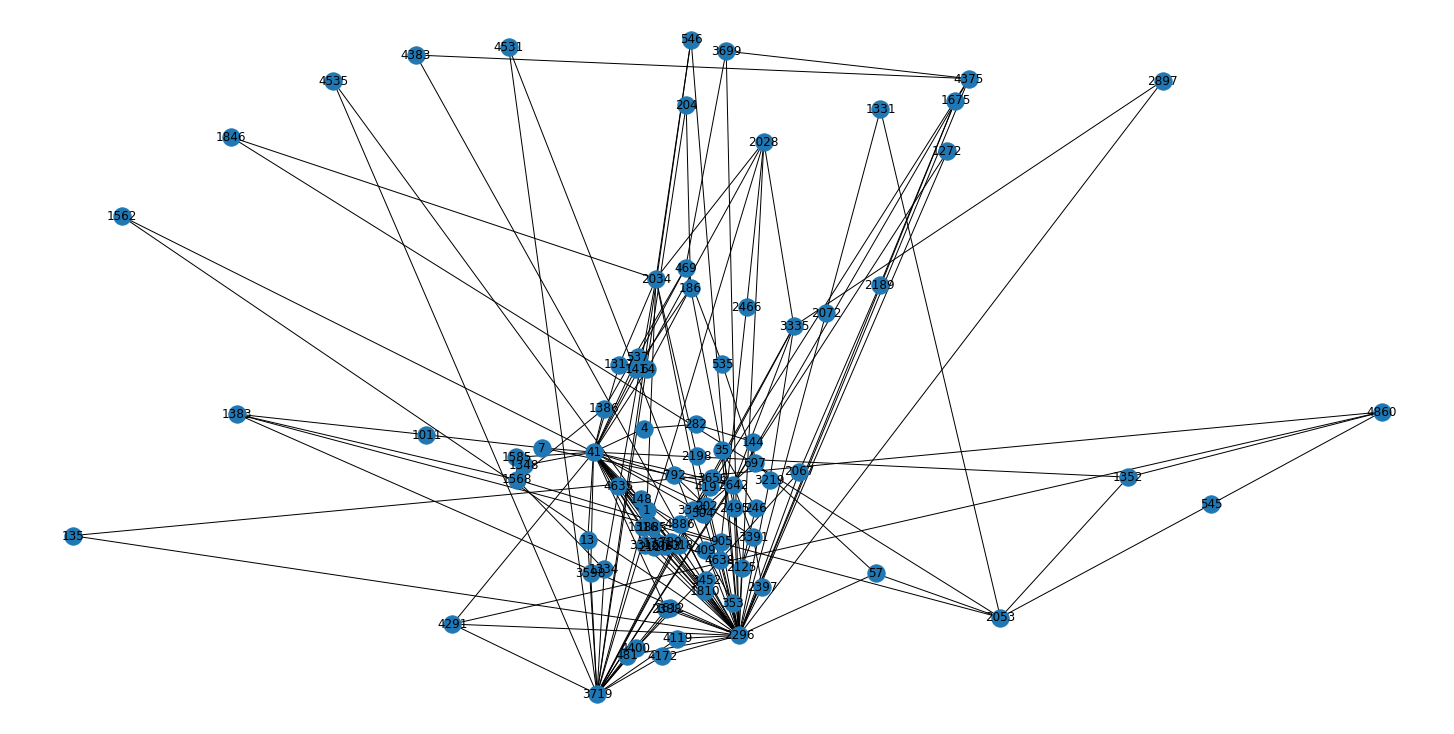

In [21]:
# Simple graph
nx.draw(trim, with_labels=True)

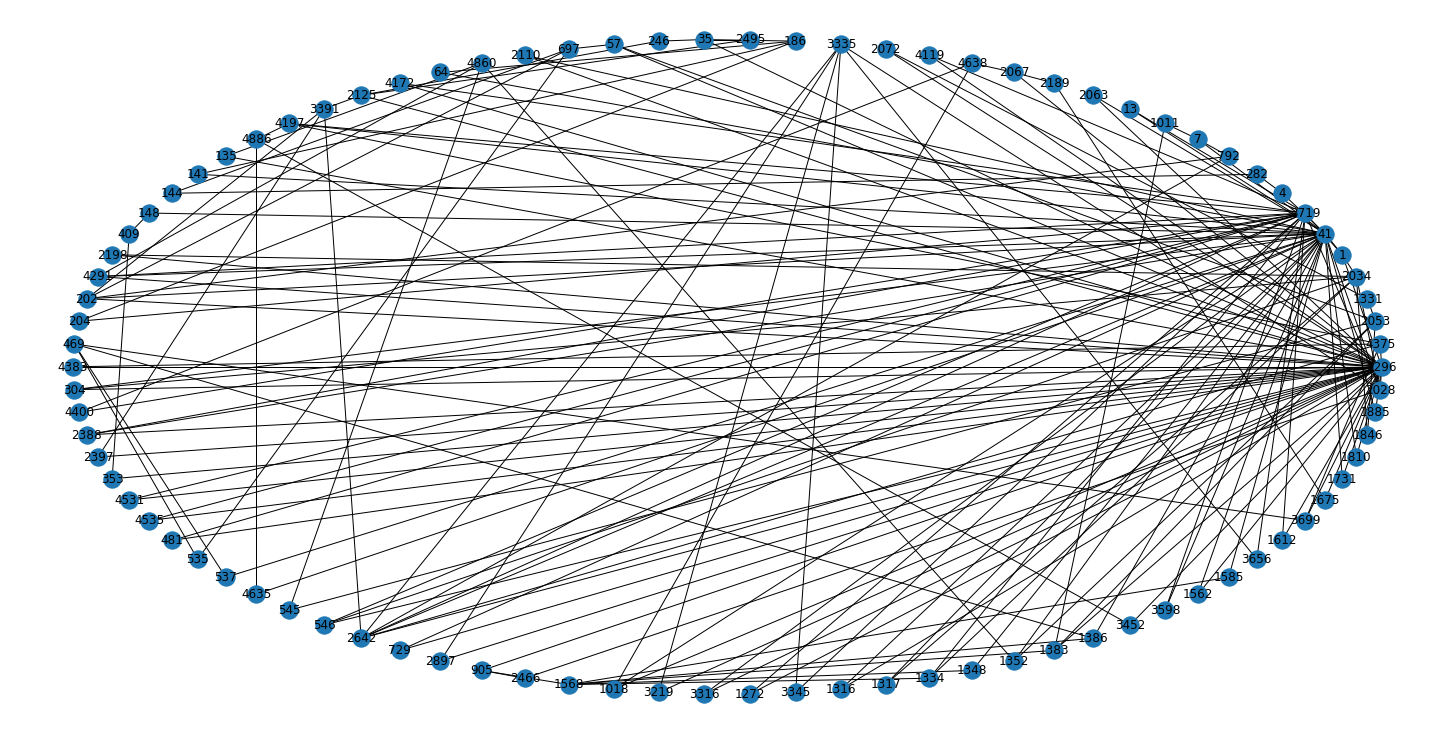

In [22]:
# Shell graph
nx.draw_shell(trim, with_labels=True)

### Graph diagnostics

Here we compute the diameter of the graph, which is the longest distance in a finite graph.

In [23]:
nx.diameter(trim)

6

Using the closeness and betweenness metrics below we confirm what we saw just above in the shell graph, namely that nodes 2296 and 41 are the most central by the measures of closeness and betweenness.

In [31]:
# Top 10 close nodes
c = nx.closeness_centrality(trim)
close = pd.DataFrame({'closeness':c})
close = close.sort_values(by=['closeness'], ascending=False)
close.head(10)

,closeness
2296,0.556250
41,0.475936
2028,0.456410
2642,0.454082
4291,0.447236
1,0.447236
2388,0.438424
202,0.434146
304,0.425837
1018,0.421801


In [28]:
# Top 10 between nodes
b = nx.betweenness_centrality(trim)
between = pd.DataFrame({'betweenness':b})
between = between.sort_values(by=['betweenness'], ascending=False)
between.head(10)

,betweenness
2296,0.546514
41,0.343544
3719,0.134018
202,0.049234
2642,0.046581
2028,0.046105
697,0.033057
1383,0.032908
35,0.032544
4291,0.030860
